In [1]:
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from brainflow.data_filter import DataFilter, FilterTypes
import os
from sklearn.model_selection import train_test_split

In [2]:
def process_and_epoch(mat_file):
    
    # Get EEG Channels
    eeg_data = np.array(mat_file['eeg'])
    
    # Get the index of when the starting and ending events occur
    events = mat_file['events'][:,1]
    start_times = np.where(events==32779)[0]
    end_times = np.where(events==32780)[0]


    # Get the index of when the start and end of trial are in the EEG dataset
    event_index = mat_file['events'][:,2]
    start_index = event_index[start_times]
    end_index = event_index[end_times]

    # Process EEG data set
    eeg_epoch = []
    processed_eeg = np.array([eeg_data[i].flatten() for i in range(14)])

    # Average re-referencing
    means = np.mean(processed_eeg, axis=0)
    processed_eeg = processed_eeg - means

    # Band-pass
    for i in range(14):
        DataFilter.perform_bandpass(processed_eeg[i], 128, 1.0, 48.0, 5, FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
        # DataFilter.perform_bandstop(eeg_data[i], 128, 58.0, 62.0, 2, FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)

    # Epoch data
    for i in range(len(start_index)):
        # Indexing 0:14 to remove last column (it is not eeg signal, just a status signal)
        epoch_data = ( processed_eeg[6:7, start_index[i]:end_index[i]] + processed_eeg[7:8, start_index[i]:end_index[i]] ) / 2.0
        mean = np.mean(epoch_data)
        std = np.std(epoch_data)
        normalized_data = (epoch_data - mean) / std
        
        
        eeg_epoch.append(normalized_data) # Looking at O electrodes
        # eeg_epoch.append(processed_eeg[:, start_index[i]:end_index[i]]) # Uncomment for all electrodes

    eeg_epoch = np.array(eeg_epoch)
    print(eeg_epoch.shape)
    
    return eeg_epoch

In [3]:
n_subjects = 11

labels_adaptation = [4, 2, 1, 0, 3, 4, 1, 0, 3, 2]
labels_i = [3, 1, 2, 4, 0, 1, 4, 3, 1, 2, 0, 4]
labels_ii = [3, 2, 1, 3, 0, 1, 4, 2, 3, 0, 2, 0, 2]

master_eeg = []
master_labels = []

for subject in range(n_subjects):
    prefix = ""
    if subject < 9:
        suffix = f'Data/U00{subject+1}'
    else:
        suffix = f'Data/U0{subject+1}'
        
    mat_adaptation = sio.loadmat(f'{suffix}x.mat')
    temp_epoch = process_and_epoch(mat_adaptation)
    if subject == 0:
        for j in range(len(temp_epoch)):
            master_eeg.append(temp_epoch[j])
            master_labels.append(labels_adaptation[j])
    else:
        master_eeg = np.concatenate((master_eeg, temp_epoch))
        master_labels = np.concatenate((master_labels, labels_adaptation))
    
    for sess in ['a', 'b', 'c', 'd', 'e']: 
        mat_i = sio.loadmat(f'{suffix}{sess}i.mat')
        temp_epoch = process_and_epoch(mat_i)
        if subject == 0:
            for j in range(len(temp_epoch)):
                master_eeg.append(temp_epoch[j])
                master_labels.append(labels_i[j])
        else:
            master_eeg = np.concatenate((master_eeg, temp_epoch))
            master_labels = np.concatenate((master_labels, labels_i))
        
        
        mat_ii = sio.loadmat(f'{suffix}{sess}ii.mat')
        temp_epoch = process_and_epoch(mat_ii)
        if subject == 0:
            for j in range(len(temp_epoch)):
                master_eeg.append(temp_epoch[j])
                master_labels.append(labels_ii[j])
        else:
            master_eeg = np.concatenate((master_eeg, temp_epoch))
            master_labels = np.concatenate((master_labels, labels_ii))
    
# mat_contents = sio.loadmat('Data/U001ai.mat')

(10, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(10, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(10, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(10, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(10, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(10, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(10, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)
(12, 1, 640)
(13, 1, 640)

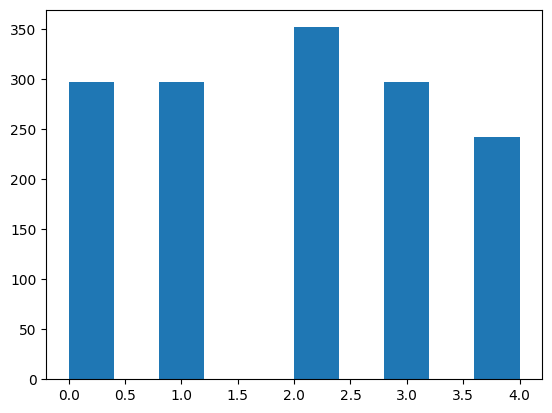

In [4]:
plt.hist(master_labels)
plt.show()

Train: (1039, 1, 640), (1039,)
Validation: (223, 1, 640), (223,)
Test: (223, 1, 640), (223,)


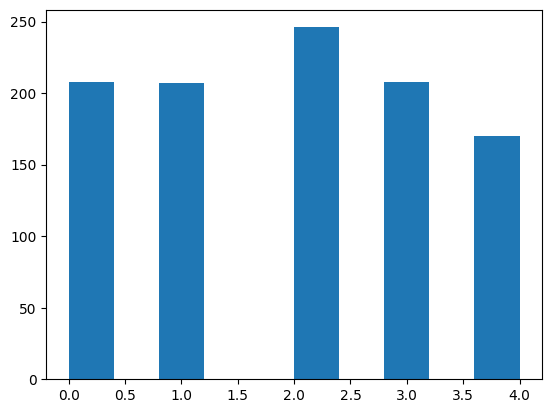

In [12]:
# Train-test split (85% train_val, 15% test)
epochs_train_val, epochs_test, labels_train_val, labels_test = train_test_split(
    master_eeg, master_labels, test_size=0.15, random_state=42, stratify=master_labels
)

# Train-validation split (from train_val)
epochs_train, epochs_val, labels_train, labels_val = train_test_split(
    epochs_train_val, labels_train_val, test_size=0.1765, random_state=42, stratify=labels_train_val
)  # 0.1765 ≈ 15% of 85%

# Check sizes
print(f"Train: {epochs_train.shape}, {labels_train.shape}")
print(f"Validation: {epochs_val.shape}, {labels_val.shape}")
print(f"Test: {epochs_test.shape}, {labels_test.shape}")

plt.hist(labels_train)
plt.show()


In [6]:
output_dir = "eeg_dataset"
os.makedirs(output_dir, exist_ok=True)

# Save splits
np.save(os.path.join(output_dir, "train_epochs.npy"), epochs_train)
np.save(os.path.join(output_dir, "train_labels.npy"), labels_train)
np.save(os.path.join(output_dir, "val_epochs.npy"), epochs_val)
np.save(os.path.join(output_dir, "val_labels.npy"), labels_val)
np.save(os.path.join(output_dir, "test_epochs.npy"), epochs_test)
np.save(os.path.join(output_dir, "test_labels.npy"), labels_test)